In [1]:
# import and filter some warnings
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np
import torch
import pyro
import os
import pyro.distributions as dist
import simulation.world_cup_simulation as wc
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

BASE_DIR = os.path.dirname(os.getcwd())
RESULTS_FULL_CSV = "data/processed/results_full.csv"
RESULTS_10Y_CSV = "data/processed/results_last_10yrs.csv"
RESULTS_5Y_CSV = "data/processed/results_last_5yrs.csv"

# load results file
ACTIVE_CSV = os.path.join(BASE_DIR, RESULTS_5Y_CSV)
df = pd.read_csv(ACTIVE_CSV)

# map teams to indices (e.g.: croatia: 1, england: 2, ...)
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}
n_teams = len(teams)

# now, transform the matches data so we can use it for the simple elo model:
# home_idx, away_idx, outcome are tensors of length n_matches.
# example entry: 12, 134, 1.0 
# example representation: croatia, Armenia, home_win
home_idx = torch.tensor([team_to_idx[t] for t in df["home_team"].values])
away_idx = torch.tensor([team_to_idx[t] for t in df["away_team"].values])
outcome = df["result"].replace({"home_win": 1.0, "away_win": 0.0, "draw": 0.5}).infer_objects()
outcome = torch.tensor(outcome.values)

In [2]:
# Pyro ELO model
def skill_model(home_idx, away_idx, outcome):
    
    # all-in-one skill (ELO) of each team (latent)
    team_skill = pyro.sample("team_skill", dist.Normal(0., 1.).expand([n_teams]).to_event(1))
    
    # win probability (observe matches to inform team skill)
    prob_home_win = torch.sigmoid(team_skill[home_idx] - team_skill[away_idx])
    
    # iterate over all matches (observed)
    with pyro.plate("matches", len(home_idx)):
        pyro.sample("obs", dist.Bernoulli(prob_home_win), obs=outcome)

In [3]:
# inference. NUTS is our sampling algorithm, MCMC is our runner that manages multiple samples.
nuts_kernel = NUTS(skill_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(home_idx, away_idx, outcome)
posterior_samples = mcmc.get_samples()["team_skill"] 

Warmup:   0%|          | 0/1200 [00:00, ?it/s]

Sample: 100%|██████████| 1200/1200 [00:14, 83.03it/s, step size=3.60e-01, acc. prob=0.837]


In [4]:
# from the posterior, we can just get the mean and work with that...
posterior_mean = posterior_samples.mean(dim=0).numpy()

team_skills_df = pd.DataFrame({
    "team": teams,
    "skill_mean": posterior_mean
}).sort_values("skill_mean", ascending=False)

team_skills_df

,team,skill_mean
74,argentina,2.724753
96,spain,2.402451
113,brazil,2.230846
18,france,2.101640
77,colombia,2.098276
...,...,...
192,timor-leste,-2.091601
222,pakistan,-2.102280
225,macau,-2.432084
3,san marino,-2.461134


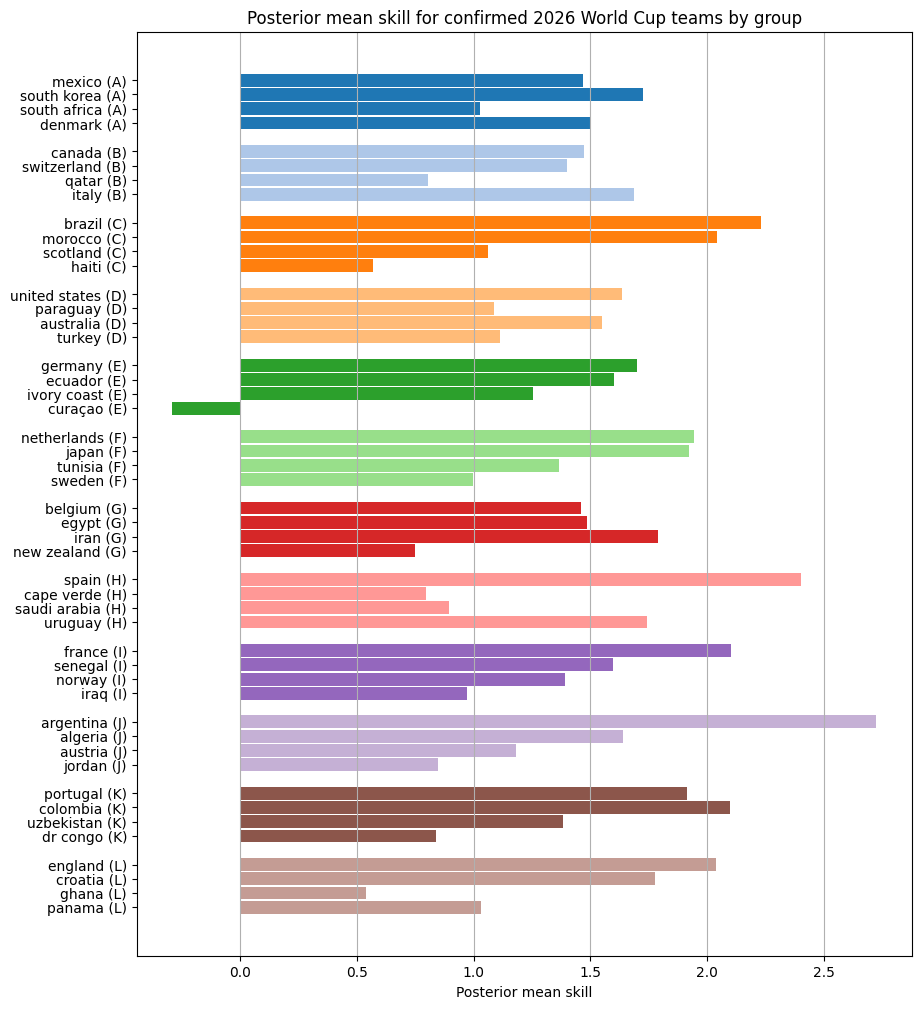

In [5]:
# from the posterior, we can just take the mean and plot that:
skills = team_skills_df.set_index("team")["skill_mean"]

plot_teams = []
plot_skills = []
plot_colors = []
group_positions = []

for i, (group, teams) in enumerate(wc.groups.items()):
    color = plt.get_cmap("tab20")(i)
    for j, team in enumerate(teams):
        if team in skills.index:
            plot_teams.append(team)
            plot_skills.append(skills.loc[team])
            plot_colors.append(color)
            # y-axis position: group index + small offset for team within group
            group_positions.append(i + j*0.2)

plt.figure(figsize=(10, 12))
plt.barh(group_positions, plot_skills, color=plot_colors, height=0.18)

# Set y-ticks to show group and team names
yticks = []
yticklabels = []
for i, (group, teams) in enumerate(wc.groups.items()):
    for j, team in enumerate(teams):
        if team in skills.index:
            yticks.append(i + j*0.2)
            yticklabels.append(f"{team} ({group})")

plt.yticks(yticks, yticklabels)
plt.gca().invert_yaxis()
plt.xlabel("Posterior mean skill")
plt.title("Posterior mean skill for confirmed 2026 World Cup teams by group")
plt.grid(axis="x")
plt.show()

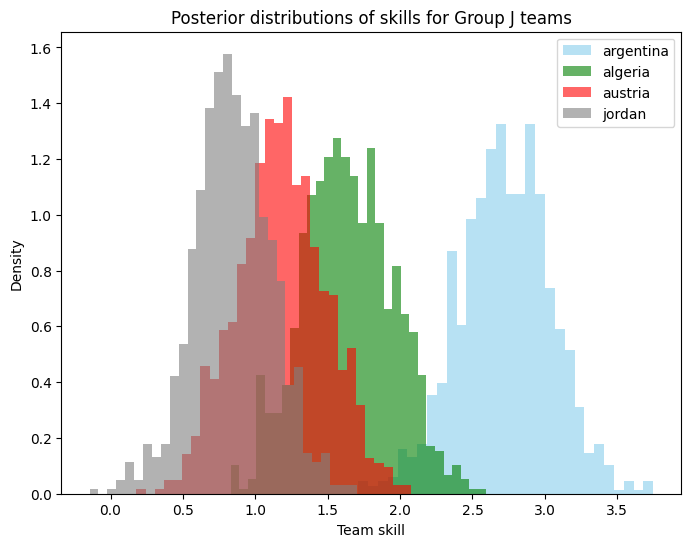

In [6]:
# ... but we will want to work with distributions...

# Suppose you want group J
group = wc.groups["J"]
colors = ["skyblue", "green", "red", "grey"] 

team_idx = {team: i for i, team in enumerate(teams)}

plt.figure(figsize=(8,6))

for i, team in enumerate(group):
    idx = team_to_idx[team]
    samples = posterior_samples[:, idx].numpy()
    plt.hist(samples, bins=30, alpha=0.6, density=True, label=team, color=colors[i])

plt.xlabel("Team skill")
plt.ylabel("Density")
plt.title("Posterior distributions of skills for Group J teams")
plt.legend()
plt.show()

In [7]:
# ... and run a first basic world simulation:

# skill_func using posterior_samples
def skill_func(team):
    idx = team_to_idx[team]
    return posterior_samples[np.random.randint(len(posterior_samples)), idx].item()


In [8]:
from collections import defaultdict

N = 1000

# dict of lists to store results for each team
all_results = defaultdict(list)

for _ in range(N):
    placements = wc.simulate_world_cup(sf=skill_func, verbose=False)
    for team, stage in placements.items():
        all_results[team].append(stage)

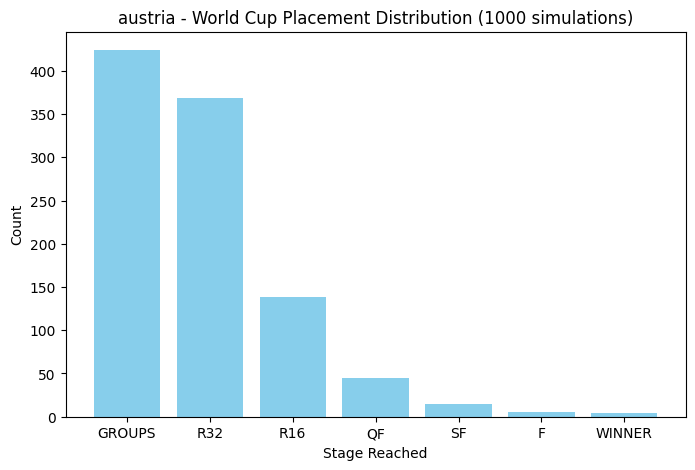

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

country = "austria"

# count placements
counts = Counter(all_results[country])

# ensure consistent order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']
counts = [counts.get(stage, 0) for stage in stages]

plt.figure(figsize=(8,5))
plt.bar(stages, counts, color='skyblue')
plt.title(country + " - World Cup Placement Distribution (" + str(N) + " simulations)")
plt.ylabel("Count")
plt.xlabel("Stage Reached")
plt.show()